**What Does The API Do?**

* Generate / modify a graphcat network that will render the figure when executed.

**What Does The Network Do?**

* Assign canvas coordinates to coordinate systems / canvas marks (box layout).
* Assign coordinates to text (text layout - special case of box layout?).
* Map data to coordinates (for some coordinate systems, e.g. Table, this might use box layout).
* Generate an SVG DOM.

In [1]:
import xml.etree.ElementTree as xml

from IPython.display import display_svg

import boxcat
import domcat
import graphcat.notebook

In [2]:
def render(graph, name, inputs):
    root = inputs.getone(None)
    top, right, bottom, left = root.get("boxcat:content")
    width = right - left
    height = bottom - top
    svg_root = xml.Element("svg", xmlns="http://www.w3.org/2000/svg",
        width=width,
        height=height,
        viewBox=f"0 0 {width} {height}",
        )
    render_element(root, svg_root)
    return svg_root


def render_element(element, svg_root):
    top, right, bottom, left = element.get("boxcat:content")
    svg_element = xml.SubElement(svg_root, "rect", x=left, y=top, width=right-left, height=bottom-top, stroke="rgba(0,0,255,0.4)", fill="none")
    svg_element = xml.SubElement(svg_root, "text", x=left+2, y=top, style="font-size: 8px; fill: rgba(0,0,255,0.4); dominant-baseline: hanging")
    svg_element.text = element.tag

    for child in element:
        render_element(child, svg_root)

In [3]:
graph = graphcat.StaticGraph()
graph.add_task("canvas", domcat.create_element("canvas", width=200, height=100))
graph.add_task("axes1", domcat.create_element("cartesian", margin="10px", padding="5px"))
graph.add_task("append1", domcat.append_element)
graph.add_links("canvas", ("append1", "parent"))
graph.add_links("axes1", ("append1", "child"))

# graph.add_task("axes2", domcat.create_element("radial", left="50%"))
# graph.add_task("append2", domcat.append_element)
# graph.add_links("append1", ("append2", "parent"))
# graph.add_links("axes2", ("append2", "child"))

graph.add_task("layout", boxcat.graphcat_layout)
graph.add_links("append1", "layout")

graph.add_task("render", render)
graph.add_links("layout", "render")

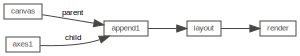

In [4]:
graphcat.notebook.display(graph)

In [5]:
domcat.dump(graph.output("append1"))

<canvas width="200" height="100">
  <cartesian margin="10px" padding="5px"/>
</canvas>


In [6]:
domcat.dump(graph.output("layout"))

<canvas width="200" height="100" boxcat:content="(0, 200.0, 100.0, 0)">
  <cartesian margin="10px" padding="5px" boxcat:content="(15.0, 185.0, 85.0, 15.0)"/>
</canvas>


In [7]:
domcat.dump(graph.output("render"))

<svg xmlns="http://www.w3.org/2000/svg" width="200.0" height="100.0" viewBox="0 0 200.0 100.0">
  <rect x="0" y="0" width="200.0" height="100.0" stroke="rgba(0,0,255,0.4)" fill="none"/>
  <text x="2" y="0" style="font-size: 8px; fill: rgba(0,0,255,0.4); dominant-baseline: hanging">
    canvas
  </text>
  <rect x="15.0" y="15.0" width="170.0" height="70.0" stroke="rgba(0,0,255,0.4)" fill="none"/>
  <text x="17.0" y="15.0" style="font-size: 8px; fill: rgba(0,0,255,0.4); dominant-baseline: hanging">
    cartesian
  </text>
</svg>


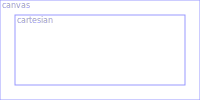

In [8]:
display_svg(domcat.tostring(graph.output("render")), raw=True)